# Generating MNIST images with DCGAN

In [ ]:
!pip install git+https://github.com/tensorflow/docs
!pip install git+https://github.com/tensorflow/examples.git

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow_examples.models.dcgan import dcgan

from dcgan import DCGAN
from target import MNISTConvTarget
from util import GANMonitor, images_to_gif

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
INPUT_SHAPE = (28, 28, 1)

LATENT_DIM = 100

## Data loading and preprocessing

Load the MNIST training set images:

In [4]:
(images, labels), (_, _) = tf.keras.datasets.mnist.load_data()
images.shape

(60000, 28, 28)

Reshape the images to `28 x 28 x 1` and normalize them to `[-1, 1]`:

In [5]:
images = images.reshape(images.shape[0], *INPUT_SHAPE).astype('float32')
images = (images - 127.5) / 127.5
images.shape

(60000, 28, 28, 1)

Shuffle and batch the data:

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## DCGAN (Deep Convolutional Generative Adversarial Network)

[DCGAN](https://arxiv.org/abs/1511.06434) is a CNN-based generative adversarial network for modeling images.

Its architecture has the following characteristics:
* pooling layers are replaced with strided convolutions (discriminator) and fractional-strided convolutions (generator)
* batch normalization is used in the discriminator and generator
* there are no fully connected hidden layers
* the generator uses the ReLU activation function in all layers except the last, which uses Tanh
* the discriminator uses the LeakyReLU activation function in all layers

### Generator

The generator receives a random noise vector as input and shapes it into an image of the desired size (`28 x 28 x 1` for MNIST) using upsampling layers (`tf.keras.layers.Conv2DTranspose`).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [7]:
generator = dcgan.make_generator_model()

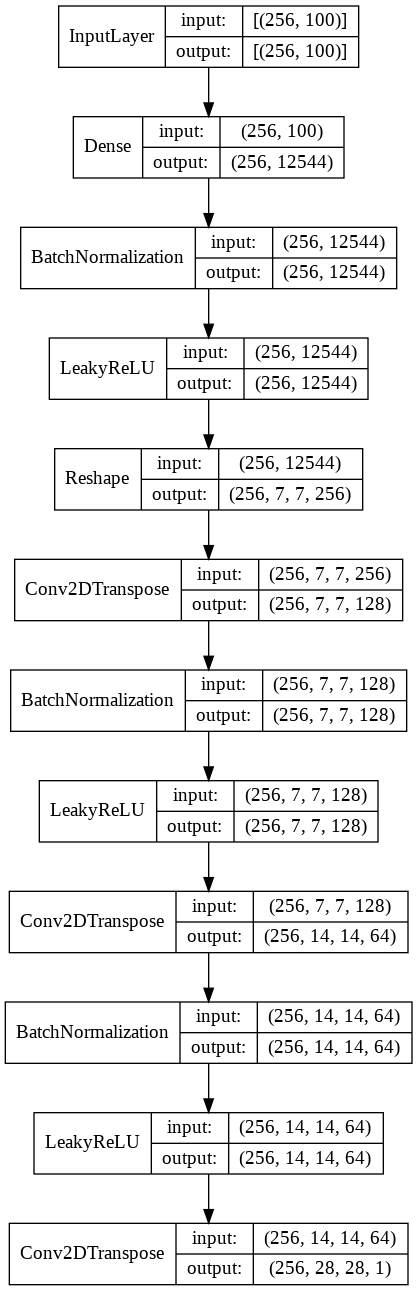

In [8]:
generator.build((BATCH_SIZE, LATENT_DIM))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False)

### Discriminator

The discriminator is a CNN-based binary classifier whose task is to differentiate between real images (from the training set) and generated images (created by the generator).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [9]:
discriminator = dcgan.make_discriminator_model()

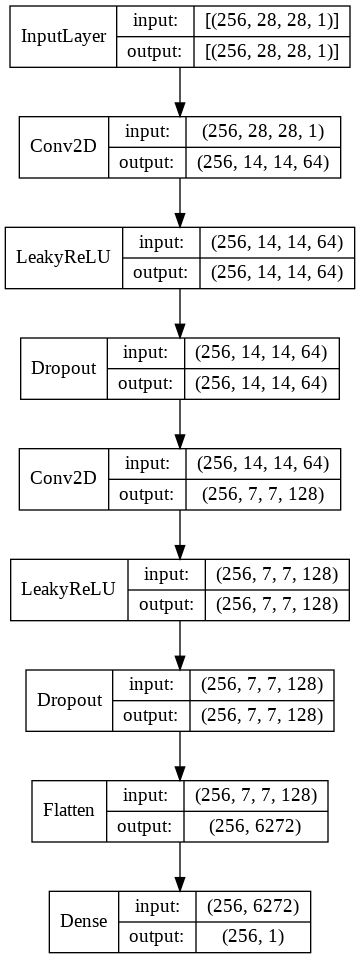

In [10]:
discriminator.build((BATCH_SIZE, *INPUT_SHAPE))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

### Training

The discriminator and the generator are trained simultaneously.

In each training step, the generator receives a batch of random noise vectors $\mathbf{z}$ as input and uses it to generate a batch of images $G(\mathbf{z})$.
The discriminator is then used to classify real images (from the training set) and generated images (produced by the generator).
The loss is calculated for the discriminator and the generator respectively, and the resulting gradients are used to update them.

#### Discriminator loss

The discriminator's loss quantifies how well it distinguishes between real images $\mathbf{x}$ and generated images $G(\mathbf{z})$. As such, it is a sum of the losses computed on the real and fake outputs, respectively:

$\mathcal{L}_D = \mathcal{L_{D,\mathrm{real}}} + \mathcal{L_{D,\mathrm{fake}}}$

For the real component, the discriminator's predictions are compared to an array of 1s, and for the fake outputs to an array of 0s:

$\mathcal{L_{D,\mathrm{real}}} = BCE(\mathbf{1}, D(\mathbf{x}))$

$\mathcal{L_{D,\mathrm{fake}}} = BCE(\mathbf{0}, D(G(\mathbf{z})))$,

where $BCE$ stands for the binary cross-entropy loss function.

#### Generator loss

The generator learns only through its interaction with the discriminator.
Its loss quantifies how well it fools the discriminator.

The generator performs well if the discriminator tends to misclassify the generated images as real (or 1).
Therefore, its loss is defined by comparing the discriminator's predictions on the fake images to an array of 1s:

$\mathcal{L}_G = BCE(\mathbf{1}, D(G(\mathbf{z})))$

Create the `DCGAN` model:

In [11]:
dcgan = DCGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=LATENT_DIM
)

Compile the model by adding the respective optimizers (two are needed because the discriminator and generator train seperately) and the base loss function:

Note that `from_logits` needs to be set to `True` as the discriminator outputs logits instead of probabilities.

In [12]:
dcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

Create a callback that periodically saves generated images:

In [13]:
NUM_IMAGES = 16

monitor = GANMonitor(
    num_images=NUM_IMAGES,
    latent_dim=LATENT_DIM,
    path_prefix='images/dcgan_mnist'
)

Finally, train the model:

Epoch 1/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9957 - g_loss: 1.0006

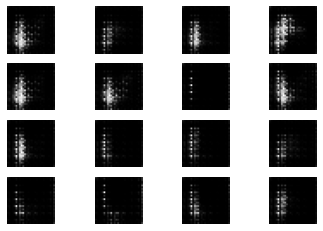

235/235 [==============================] - 29s 109ms/step - d_loss: 0.9947 - g_loss: 1.0035
Epoch 2/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9828 - g_loss: 1.3326

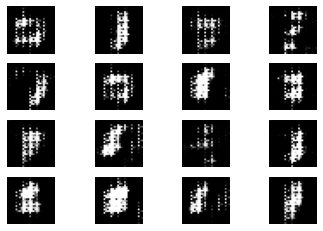

235/235 [==============================] - 26s 109ms/step - d_loss: 0.9831 - g_loss: 1.3349
Epoch 3/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0884 - g_loss: 1.2029

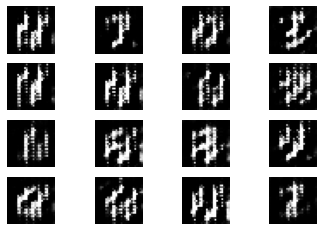

235/235 [==============================] - 26s 110ms/step - d_loss: 1.0888 - g_loss: 1.2020
Epoch 4/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0318 - g_loss: 1.3486

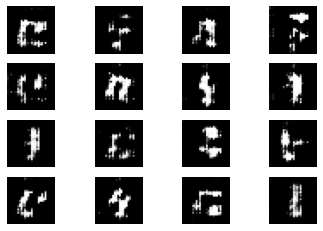

235/235 [==============================] - 26s 110ms/step - d_loss: 1.0318 - g_loss: 1.3481
Epoch 5/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1168 - g_loss: 1.3676

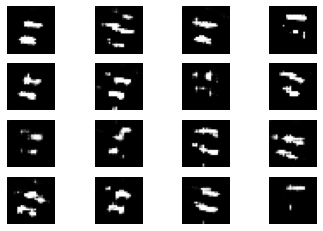

235/235 [==============================] - 25s 107ms/step - d_loss: 1.1161 - g_loss: 1.3669
Epoch 6/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0464 - g_loss: 1.2701

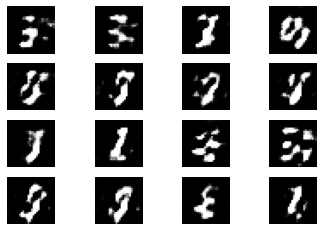

235/235 [==============================] - 26s 109ms/step - d_loss: 1.0463 - g_loss: 1.2698
Epoch 7/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0155 - g_loss: 1.3059

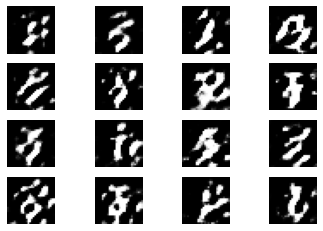

235/235 [==============================] - 26s 111ms/step - d_loss: 1.0171 - g_loss: 1.3049
Epoch 8/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0123 - g_loss: 1.3053

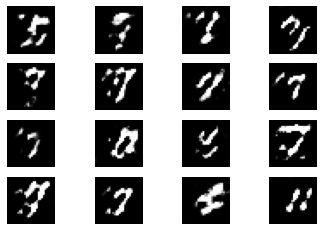

235/235 [==============================] - 26s 110ms/step - d_loss: 1.0126 - g_loss: 1.3052
Epoch 9/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0488 - g_loss: 1.3583

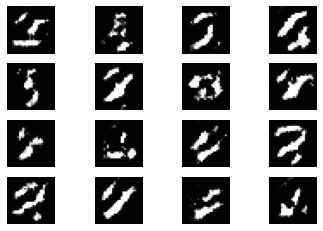

235/235 [==============================] - 26s 109ms/step - d_loss: 1.0487 - g_loss: 1.3592
Epoch 10/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9702 - g_loss: 1.4805

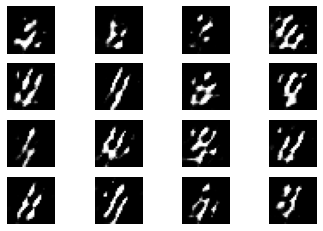

235/235 [==============================] - 26s 110ms/step - d_loss: 0.9691 - g_loss: 1.4816
Epoch 11/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9084 - g_loss: 1.7031

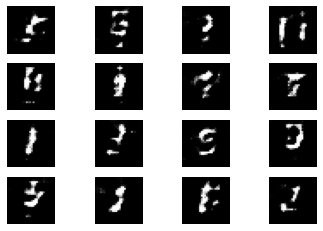

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9091 - g_loss: 1.7019
Epoch 12/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9630 - g_loss: 1.4374

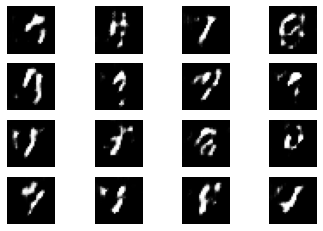

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9640 - g_loss: 1.4376
Epoch 13/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9323 - g_loss: 1.5028

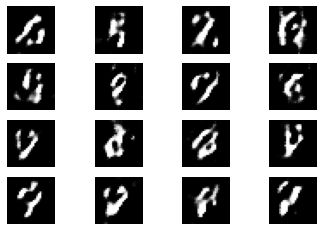

235/235 [==============================] - 26s 110ms/step - d_loss: 0.9330 - g_loss: 1.5037
Epoch 14/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9660 - g_loss: 1.5381

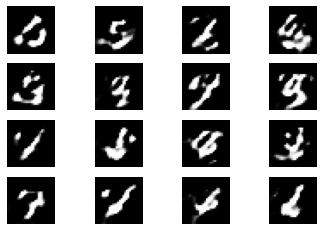

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9668 - g_loss: 1.5375
Epoch 15/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9987 - g_loss: 1.3990

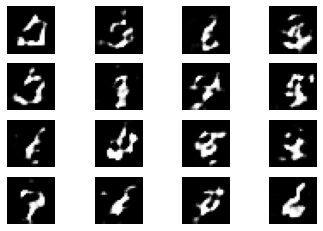

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9978 - g_loss: 1.3992
Epoch 16/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9258 - g_loss: 1.5442

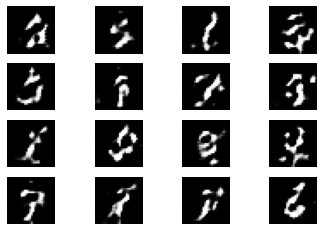

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9250 - g_loss: 1.5441
Epoch 17/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9392 - g_loss: 1.5886

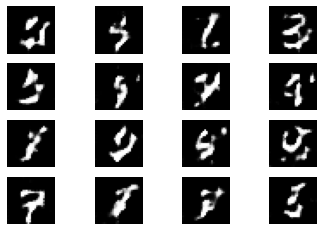

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9390 - g_loss: 1.5904
Epoch 18/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9275 - g_loss: 1.5653

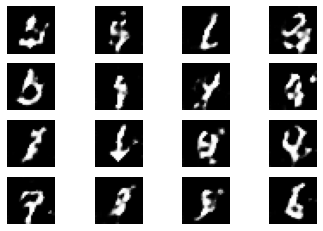

235/235 [==============================] - 26s 112ms/step - d_loss: 0.9271 - g_loss: 1.5654
Epoch 19/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9212 - g_loss: 1.5946

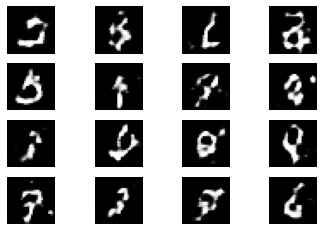

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9204 - g_loss: 1.5957
Epoch 20/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9387 - g_loss: 1.5683

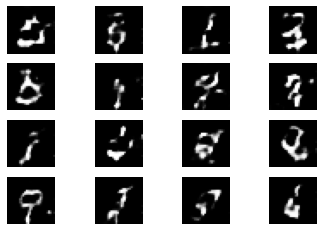

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9387 - g_loss: 1.5681
Epoch 21/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9125 - g_loss: 1.6353

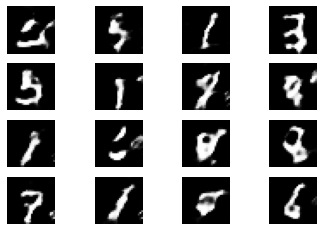

235/235 [==============================] - 26s 110ms/step - d_loss: 0.9121 - g_loss: 1.6364
Epoch 22/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9605 - g_loss: 1.5490

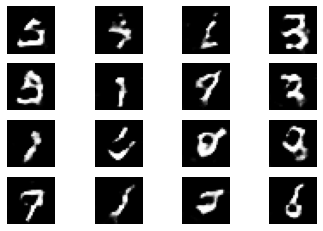

235/235 [==============================] - 26s 112ms/step - d_loss: 0.9610 - g_loss: 1.5482
Epoch 23/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9911 - g_loss: 1.4916

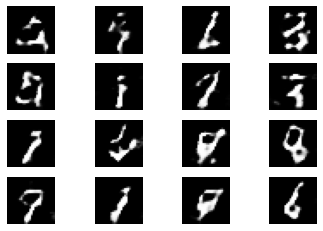

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9918 - g_loss: 1.4914
Epoch 24/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9917 - g_loss: 1.4697

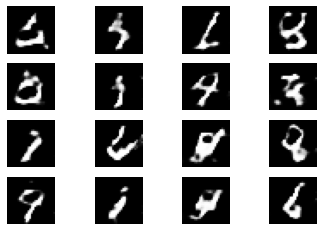

235/235 [==============================] - 26s 111ms/step - d_loss: 0.9929 - g_loss: 1.4684
Epoch 25/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9996 - g_loss: 1.4833

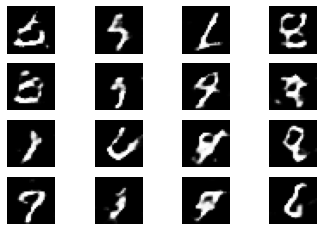

235/235 [==============================] - 26s 112ms/step - d_loss: 0.9995 - g_loss: 1.4831
Epoch 26/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0502 - g_loss: 1.3901

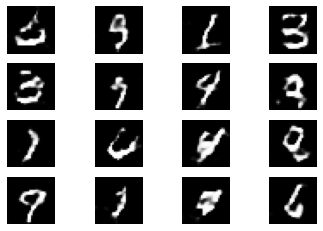

235/235 [==============================] - 26s 111ms/step - d_loss: 1.0510 - g_loss: 1.3895
Epoch 27/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0448 - g_loss: 1.3340

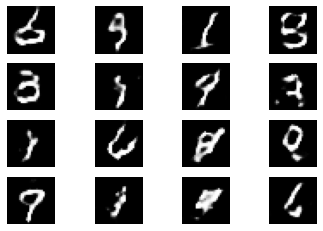

235/235 [==============================] - 26s 112ms/step - d_loss: 1.0445 - g_loss: 1.3335
Epoch 28/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0867 - g_loss: 1.2713

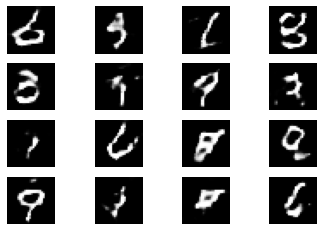

235/235 [==============================] - 26s 111ms/step - d_loss: 1.0862 - g_loss: 1.2723
Epoch 29/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0622 - g_loss: 1.3190

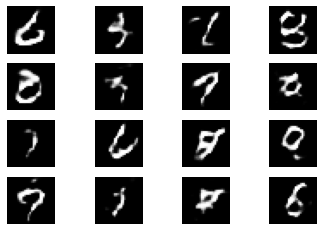

235/235 [==============================] - 26s 112ms/step - d_loss: 1.0615 - g_loss: 1.3190
Epoch 30/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0992 - g_loss: 1.2606

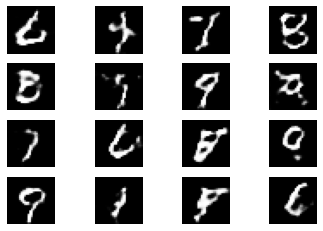

235/235 [==============================] - 26s 111ms/step - d_loss: 1.0996 - g_loss: 1.2607
Epoch 31/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0864 - g_loss: 1.2723

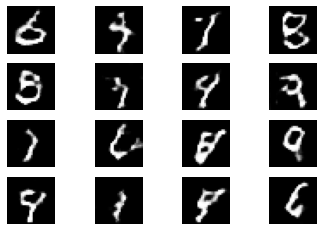

235/235 [==============================] - 26s 111ms/step - d_loss: 1.0874 - g_loss: 1.2723
Epoch 32/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1199 - g_loss: 1.2141

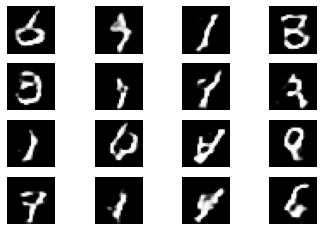

235/235 [==============================] - 26s 110ms/step - d_loss: 1.1194 - g_loss: 1.2143
Epoch 33/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1109 - g_loss: 1.1820

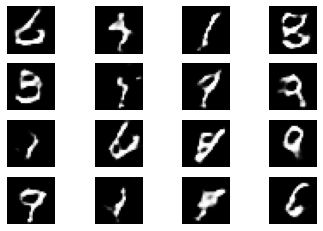

235/235 [==============================] - 26s 111ms/step - d_loss: 1.1114 - g_loss: 1.1819
Epoch 34/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1254 - g_loss: 1.2143

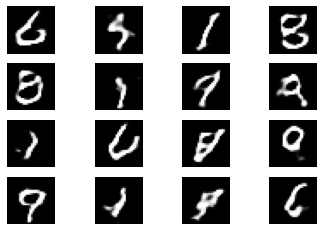

235/235 [==============================] - 26s 110ms/step - d_loss: 1.1255 - g_loss: 1.2144
Epoch 35/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1136 - g_loss: 1.2406

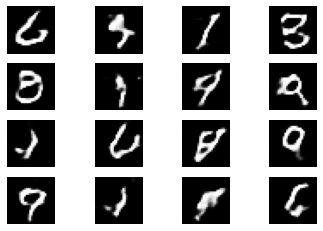

235/235 [==============================] - 26s 111ms/step - d_loss: 1.1140 - g_loss: 1.2404
Epoch 36/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1460 - g_loss: 1.1531

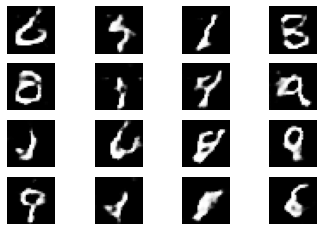

235/235 [==============================] - 26s 112ms/step - d_loss: 1.1468 - g_loss: 1.1525
Epoch 37/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1127 - g_loss: 1.2364

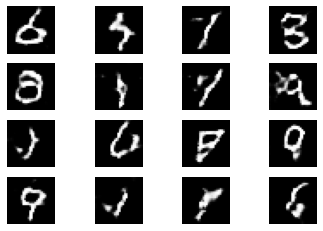

235/235 [==============================] - 26s 111ms/step - d_loss: 1.1123 - g_loss: 1.2361
Epoch 38/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1020 - g_loss: 1.2596

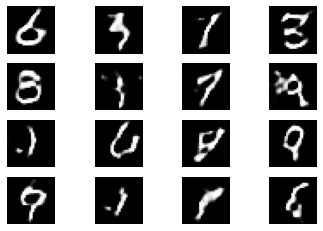

235/235 [==============================] - 26s 111ms/step - d_loss: 1.1024 - g_loss: 1.2591
Epoch 39/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1572 - g_loss: 1.1454

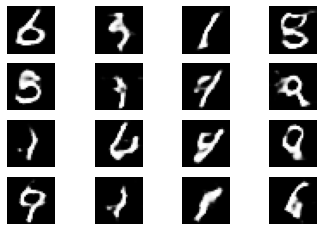

235/235 [==============================] - 26s 110ms/step - d_loss: 1.1578 - g_loss: 1.1450
Epoch 40/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1422 - g_loss: 1.1080

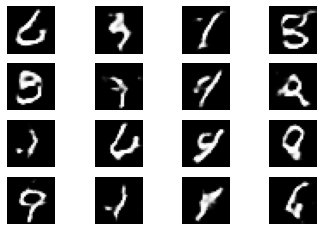

235/235 [==============================] - 26s 112ms/step - d_loss: 1.1420 - g_loss: 1.1080
Epoch 41/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1416 - g_loss: 1.1290

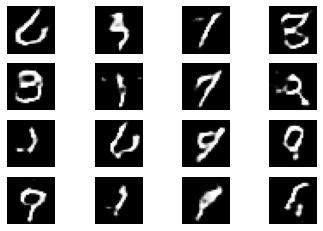

235/235 [==============================] - 26s 110ms/step - d_loss: 1.1406 - g_loss: 1.1307
Epoch 42/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1214 - g_loss: 1.1717

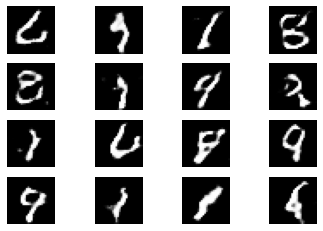

235/235 [==============================] - 26s 110ms/step - d_loss: 1.1213 - g_loss: 1.1722
Epoch 43/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1520 - g_loss: 1.1831

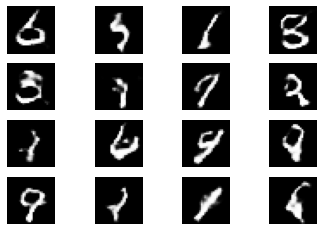

235/235 [==============================] - 26s 111ms/step - d_loss: 1.1521 - g_loss: 1.1828
Epoch 44/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1671 - g_loss: 1.1143

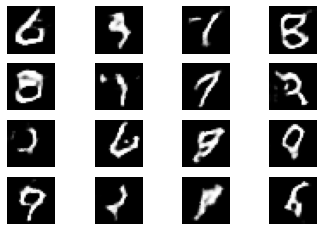

235/235 [==============================] - 26s 112ms/step - d_loss: 1.1676 - g_loss: 1.1140
Epoch 45/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1422 - g_loss: 1.1564

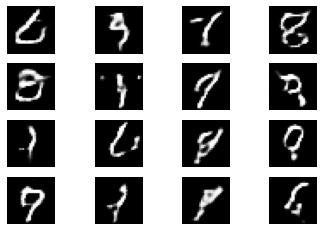

235/235 [==============================] - 26s 110ms/step - d_loss: 1.1413 - g_loss: 1.1571
Epoch 46/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1120 - g_loss: 1.2464

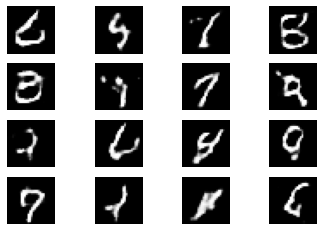

235/235 [==============================] - 26s 110ms/step - d_loss: 1.1110 - g_loss: 1.2464
Epoch 47/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1361 - g_loss: 1.1925

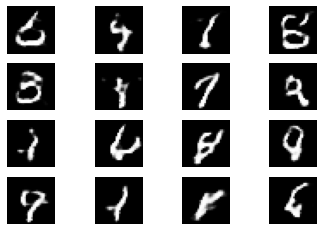

235/235 [==============================] - 26s 112ms/step - d_loss: 1.1369 - g_loss: 1.1927
Epoch 48/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1394 - g_loss: 1.1655

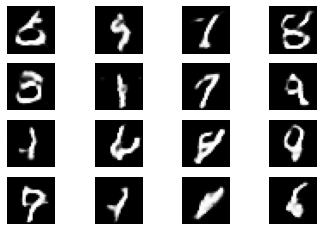

235/235 [==============================] - 26s 111ms/step - d_loss: 1.1395 - g_loss: 1.1664
Epoch 49/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1692 - g_loss: 1.1250

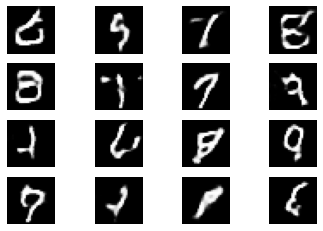

235/235 [==============================] - 26s 109ms/step - d_loss: 1.1700 - g_loss: 1.1244
Epoch 50/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1634 - g_loss: 1.0858

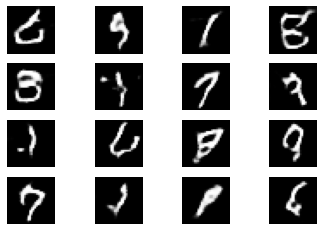

235/235 [==============================] - 26s 111ms/step - d_loss: 1.1628 - g_loss: 1.0857


In [14]:
history = dcgan.fit(
    dataset,
    epochs=50,
    callbacks=[monitor]
)

In [23]:
import time

weights_path = f'training/dcgan_mnist_{time.strftime("%Y%m%d%H%M%S")}.h5'
dcgan.save_weights(weights_path)

Plot the generator and discriminator losses through the epochs:

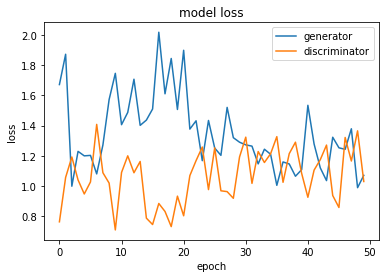

In [24]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='best')

plt.show()

Plot the generator's progress through the epochs:

In [25]:
gif_path = 'images/dcgan_mnist.gif'

images_to_gif(image_pattern='images/dcgan_mnist*.png', gif_path=gif_path)


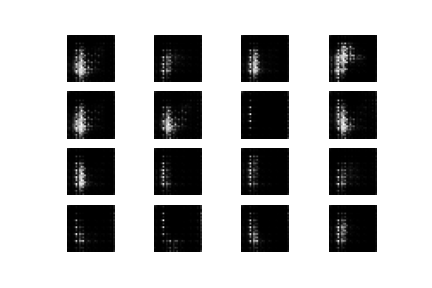

In [26]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(gif_path)

### Classifying the generated images using `MNISTConvTarget`

We'll test the generator's performance by classifying the images it creates using the `MNISTConvTarget` model.

Load the pre-trained `MNISTConvTarget` model:

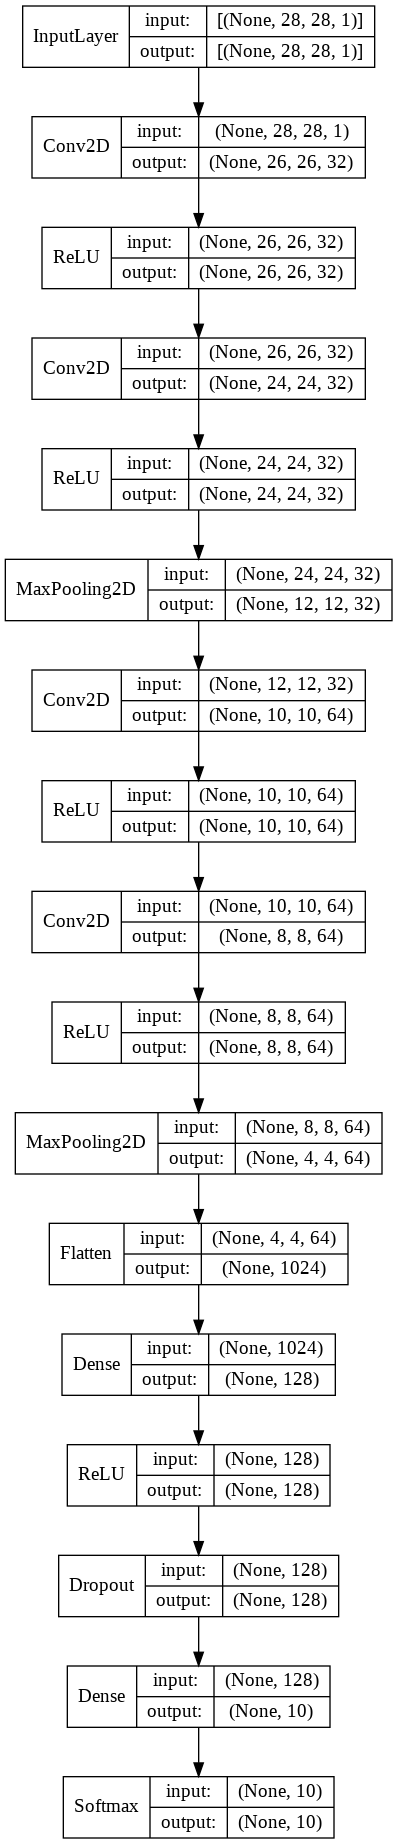

In [19]:
target = MNISTConvTarget()
tf.keras.utils.plot_model(target.model, show_shapes=True, show_layer_names=False)

In [20]:
weights_path = 'training/mnist_conv_target_20220106120545.h5'

target.built = True
target.load_weights(weights_path)

target.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

Generate and display the images:

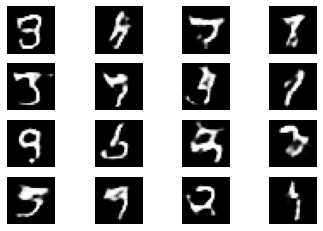

In [21]:
noise = tf.random.normal(shape=(NUM_IMAGES, LATENT_DIM))
generated_images = dcgan.generator(noise, training=False)

for i in range(NUM_IMAGES):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

Classify those images using `MNISTConvTarget`:

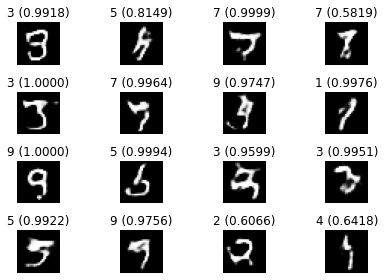

In [22]:
target_label_probs = target.predict(generated_images)

max_probs = target_label_probs.max(axis=1)
assigned_labels = target_label_probs.argmax(axis=1)

for i in range(NUM_IMAGES):
    ax = plt.subplot(4, 4, i + 1)
    ax.set_title(f'{assigned_labels[i]} ({max_probs[i]:.4f})')

    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
